# Quadcopter

- ins_nav referencing GPS position: `gpsins_gnc05.pdf`
    - rotation: ECEF to NED ($A^N_E$)
    - rotation: NED to body (std aerospace rot) ($A^B_N$)
    - KF in ECEF frame
        - covariance (P): 
            - $P^{NED}_{att} = A^N_E P^{ECEF}_{att} A^E_N$
            - $P^{NED}_{vel} = A^N_E P^{ECEF}_{vel} A^E_N$
    - Error:
        - $\delta q = q \otimes \hat q ^{-1}$
        
- [intechopen.com: KF intro](https://www.intechopen.com/chapters/63164)
    - System
        - Dynamics model: $x_k=f(x_{k−1}, u_{k−1}) + w_{k−1}$ 
            - where $w_{k−1} = N(0,Q)$
        - Measurement model: $z_k=h(x_k) + v_k $ 
            - where $v_k = N(0,R)$
    - Predicted 
        - state est: $\hat x^{-}_k = f(\hat x^{+}_{k-1}, u_{k-1}$
        - error cov: $P^-_k = F_{k-1} P^+_{k-1} F^T_{k-1} + Q$
    - Update
        1. measurement residual: $y = z_k - h(\hat x^-_k)$
        1. kalman gain: $K_k = P^-_k H^T_k(R + H_k P^-_k H^T_k)^{-1}$
        1. state est: $\hat x^{+}_k = \hat x^{-}_k + K_k y$
        1. error cov: $P^+_k = (I - K_k H_k) P^-_k$
    - Initialize
        - $Q = diag([\sigma^2, ...])$, where $\sigma$ is the tuning parameter on how uncertain the estimate is
        - $R = diag([\sigma^2, ...])$, where $\sigma^2$ is the variance of the gausian noise seen by the sensors

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

In [96]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

from spiceweasel import EKF
from matplotlib import pyplot as plt
from thundercougarfalconbird import Drone # model
from scipy.integrate import solve_ivp as ode  # integration
# from collections import namedtuple
from tqdm import tqdm
from squaternion import Quaternion
from yivo import Yivo
from yivo.packet import ImuAGMQPT
import pickle

In [13]:
def altitude(p):
    """
    Given a pressure (Pa), this calculates an altitude (m)
    """
    g0 = 9.80665 # m / s^2
    M = 0.0289644 # kg / mol
    R = 8.31446261815324 # Nm/(mol K)
    Lb = -0.0065 # K/m
    Tb = 288.15 # K
    Pb = 101325.0 # Pa
    return Tb/Lb*((p/Pb)**(-R*Lb/(g0*M)) - 1.0)

In [163]:
def get_data(fname):
    with open(fname, "rb") as fd:
        data = pickle.load(fd)
    print(f">> Loaded {fname} with {len(data)} data points")
    return data

"""
agmqpt-still: quad flat on table, no movement
qgmqpt-simple: up/down x2, roll/pitch
"""
data = get_data("data/agmqpt-simple.pkl")
data = list(data)
print(data[0])

u = []
att = []
alt = []
ts = []
for x in data[:2000]:
    if type(x) == ImuAGMQPT:
        t = tuple(x)
        u.append(t[:6])
        att.append(t[10:14])
        alt.append(altitude(t[-3]))
        ts.append(t[-1])
u = np.array(u)    
att = np.array(att)
alt = np.array(alt) - alt[0]
ts = 0.001*(np.array(ts) - ts[0])

>> Loaded data/agmqpt-simple.pkl with 4472 data points
ImuAGMQPT(ax=-0.005638979375362396, ay=-0.012720983475446701, az=1.00650954246521, wx=0.023459892719984055, wy=0.002130528911948204, wz=0.007456851191818714, imu_temp=26.87890625, mx=-27.443134307861328, my=0.8935298919677734, mz=-49.49604034423828, qw=0.9999771118164062, qx=-0.0028364548925310373, qy=0.0031502791680395603, qz=0.0012168458197265863, pressure=83508.078125, temperature=25.513626098632812, ts=36784811)


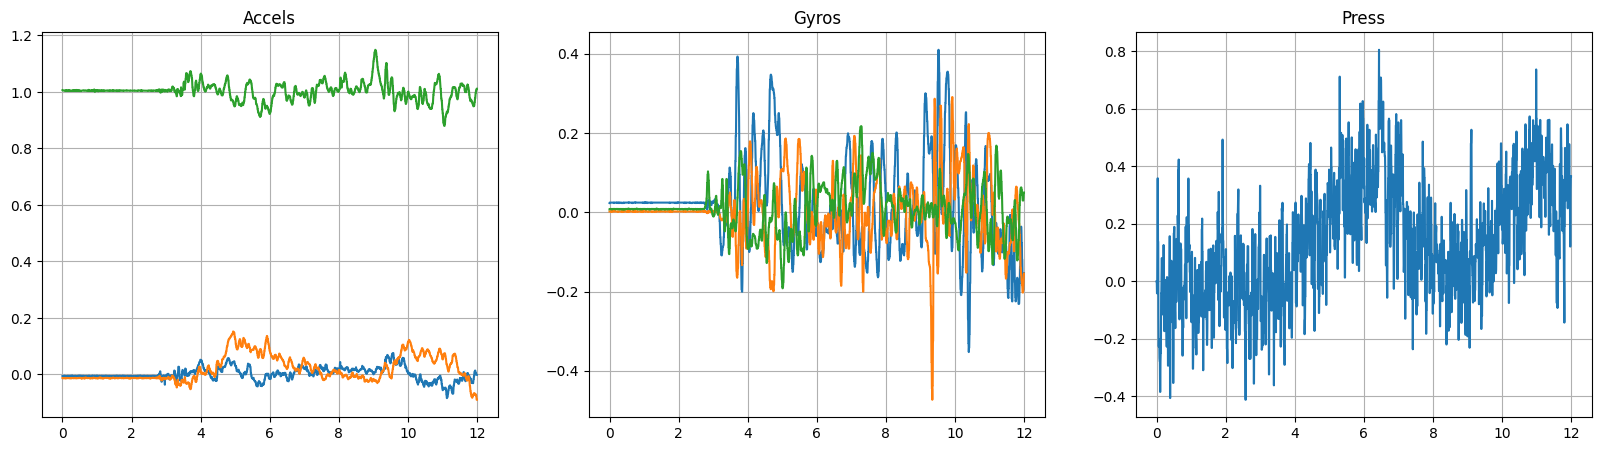

In [164]:
plt.figure(figsize=(20,5))
plt.subplot(131);plt.plot(ts,u[:,:3]);plt.title("Accels");plt.grid(True)
plt.subplot(132);plt.plot(ts,u[:,3:6]);plt.title("Gyros");plt.grid(True)
plt.subplot(133);plt.plot(ts,alt);plt.title("Press");plt.grid(True)

In [165]:
def eom(dt, X, u):
    """
          0  1  2  3  4  5  6  7  8  9
    X = [vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    u = [fx fy fz wx wy wz]
    f - force
    w - angular velocity
    """
    v = X[0:3]
    p = X[3:6]
    q = Quaternion(*X[6:10])
    
    f = u[0:3] # accels
    w = u[3:6]  # gyros
    
    wie = np.array([0, 0, 7.292115E-15])
    Cnb = np.array(q.to_rot())
    g = -9.8
    ng = np.array([0,0,1.0])
    
    dv = -2.0*np.cross(wie, np.cross(wie, v))-np.cross(wie, np.cross(wie, p)) + g*(Cnb.dot(f)-ng)
    dp = v
    dq = 0.5 * q * Quaternion(0,*w)

    XX = np.hstack((dv, dp, dq))
    return XX

In [169]:
def filter(att,alt,uu,t, func):
    yi = []
    tr = []
    # create a kalman filter
    ekf = EKF(func, 0.01, 10, 10)

    # so reset puts R and Q to identify matrix, you should
    # adjust them to your system
    ekf.reset()
    
    # barometer: +/- 0.5m, variance: 0.5^2
    ekf.P = np.diag([200,200,200,  200,200, .5**2,  .5,.5,.5,.5])
    
    vr = 10
    pr = 10
    qr = 0.5
    bar = 0.5**2
    ekf.R = np.diag([vr,vr,vr, pr,pr,bar, qr,qr,qr,qr]) # rms sensor noise squared
    
    ekf.Q = np.diag([10*vr,10*vr,10*vr, pr,pr,bar, qr,qr,qr,qr]) # system noise
    
    ekf.H = np.diag([0,0,0, 0,0,1, 1,1,1,1]) # only measure position, not vel
    
    ekf.x = np.array([0,0,0, 0,0,0, 1,0,0,0]) # default sets this to zeros
    
    dts = np.insert(np.diff(t), 0, 0.006)
    
    for q, h, u, dt in zip(att,alt,uu,dts):
        ekf.predict(u, dt)
        # meas = np.array([ekf.x[0],p])
        q = Quaternion(*q).normalize
        meas = np.array([0,0,0, 0,0,h, *q])
        y = ekf.update(meas)
        yi.append(y)
        
        # tr.append(np.trace(ekf.P))
        tr.append(np.sqrt(np.diagonal(ekf.P)))

    yi = np.array(yi)
    tr = np.array(tr)
    print(np.diagonal(ekf.P))
    
    return yi, tr
    
# step = 0.01
ekf, tr = filter(att,alt,u,ts,eom)

[199.    198.995 199.066 209.083 209.073   0.25    0.251   0.251   0.251
   0.251]


Text(0.5, 1.0, 'sqrt(diag(P))')

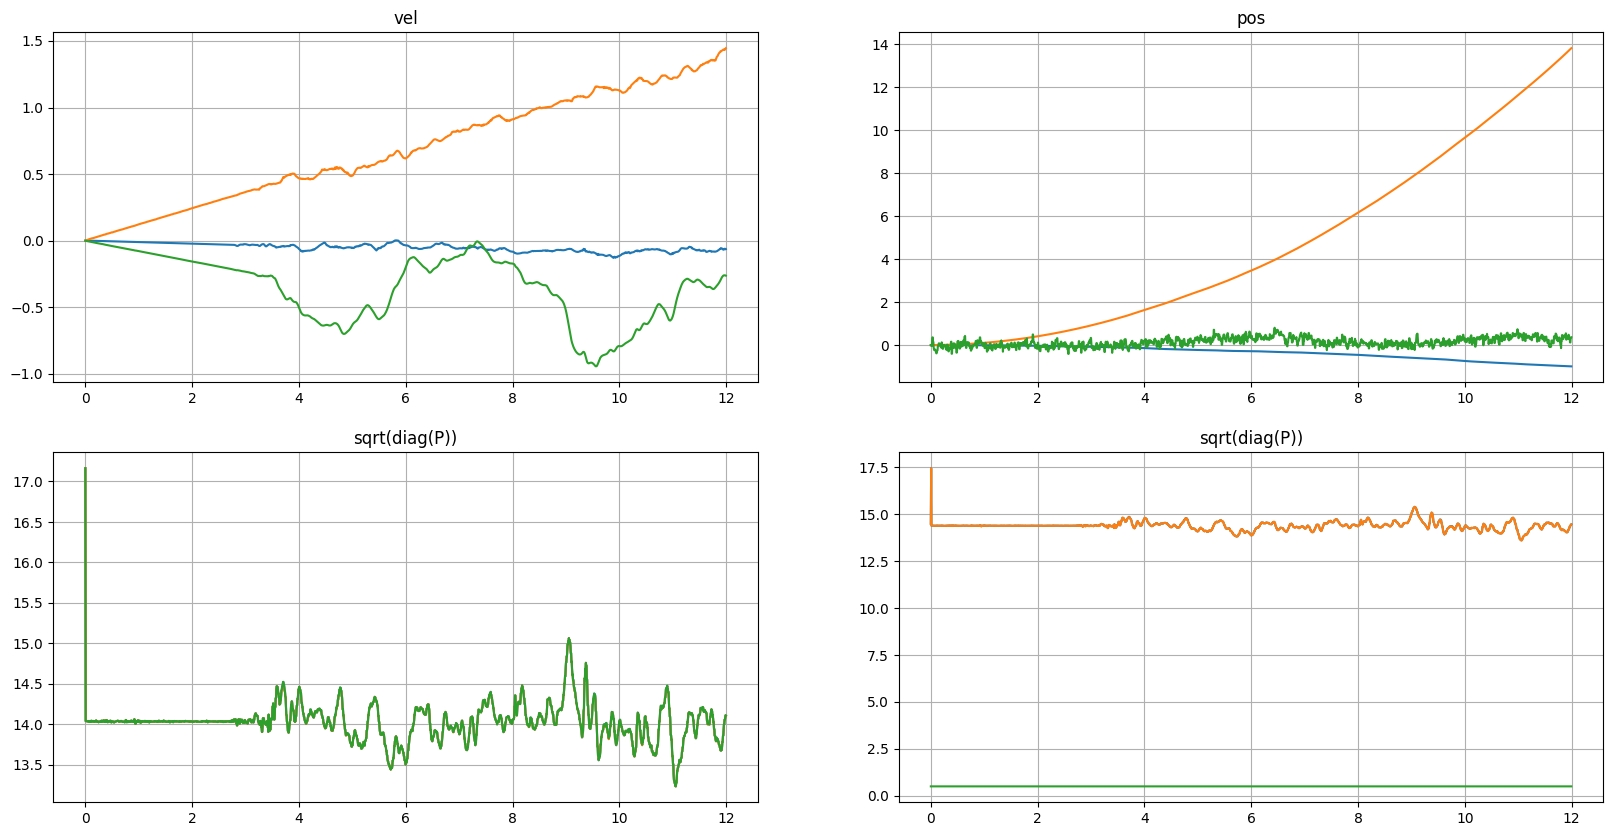

In [171]:
v = ekf[:,:3]
p = ekf[:,3:6]
q = ekf[:,6:]
euler = np.array([Quaternion(*x).to_euler(degrees=True) for x in q])
t = ts

plt.figure(figsize=(20,10))
plt.subplot(221);plt.plot(t,v);plt.grid(True);plt.title("vel")
plt.subplot(222);plt.plot(t,p);plt.grid(True);plt.title("pos")
# plt.subplot(223);plt.plot(t,q);plt.grid(True);plt.title("quaternion")
plt.subplot(223);plt.plot(t,tr[:,:3]);plt.grid(True);plt.title("vel sqrt(diag(P))")
plt.subplot(224);plt.plot(t,tr[:,3:6]);plt.grid(True);plt.title("pos sqrt(diag(P))")
# plt.subplot(224);plt.plot(p[:,0],p[:,1]);plt.grid(True);plt.xlabel("x");plt.ylabel("y");
# plt.subplot(224);plt.plot(t,euler);plt.grid(True);plt.title("euler");

In [101]:
tr[100]

977.5392551265496

In [89]:
np.trace(np.ones((10,10))*100)

1000.0

In [43]:
np.max(np.diff(ts))

0.006000000000000227

In [48]:
hz = 1/np.diff(ts)
np.max(hz)

166.66666666675903

In [107]:
np.std(alt)**2
0.75**2

0.5625

In [71]:
np.random.normal(0,.001,(maxSize,1)).shape

(1000, 1)

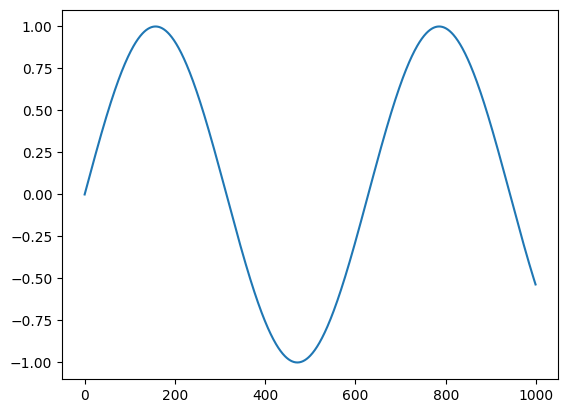

In [81]:
plt.plot(np.sin(0.01*np.arange(maxSize)).reshape((maxSize,1)))

In [104]:
np.linalg.norm([.5,.5,.5,.5])

1.0

In [155]:
np.diff(np.arange(10))

array([1, 1, 1, 1, 1, 1, 1, 1, 1])

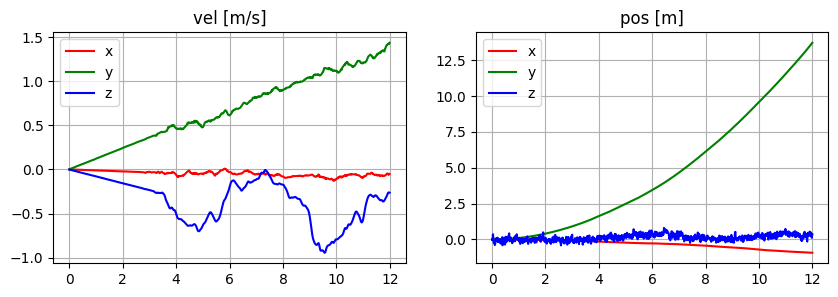

In [168]:
def plot3(f,t,x,r,c,i,title):
    ax1 = f.add_subplot(r,c,i)
    ax1.plot(t,x[:,0], color="red", label="x")
    ax1.plot(t,x[:,1], color="green", label="y")
    ax1.plot(t,x[:,2], color="blue", label="z")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    return f

f = plt.figure(figsize=(10,3))
f = plot3(f,t,v,1,2,1,"vel [m/s]")
f = plot3(f,t,p,1,2,2,"pos [m]")